In [7]:
import cv2
import numpy as np
from torchvision.datasets import CocoCaptions
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize
import torchvision

## Unet

In [8]:
import Detection.GroundingDINO.groundingdino.datasets.transforms as T

transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )


In [9]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self,phase, transform):
        self.phase = phase
        
        if phase == 'train':
            self.dataset = CocoCaptions(root='./train2017', annFile='./annotations/captions_train2017.json')
        else:
            self.dataset = CocoCaptions(root='./val2017', annFile='./annotations/captions_val2017.json')
        
        self.transform = transform
        
        
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        
        org_img, caps = self.dataset[idx]

        img,_ = self.transform(org_img, None)
        
        random_idx = torch.randint(0,len(caps), (1,))
        
        if self.phase == 'train':
            return np.array(org_img), img, caps[random_idx]
        else:
            return np.array(org_img), img, caps[1]


In [10]:
from SResolution.TG_Umodels import *

def select_model(down_scale, shape):
    if down_scale == 2:
        model = TG_UNet2(3,3, shape)
    elif down_scale == 4:
        model = TG_UNet4x2(3,3, shape)
    elif down_scale == 8:
        model = TG_UNet8x2(3,3, shape)

    return model

In [11]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [12]:


down_scale = 4
input_shape = (128,128)
model = select_model(down_scale,input_shape)
patience = 5
L2 = nn.MSELoss()
L1 = nn.L1Loss()
per_loss = VGGPerceptualLoss()
lam = 0.6
epochs = 50
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
per_loss = per_loss.to(device)


print(device)


c:\Users\juniy\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\juniy\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler, DataLoader, Subset

trainDataset = CustomDataset('train', transform)

num_train_samples = 1000
sample_ds = Subset(trainDataset, np.arange(num_train_samples))
sample_sampler = RandomSampler(sample_ds)
# sample_dl = DataLoader(sample_ds, sampler=sample_sampler, batch_size=1)
train_dataloader = DataLoader(sample_ds, batch_size=1, shuffle=True)

valDataset = CustomDataset('val', transform)
num_train_samples = 200
sample_ds = Subset(valDataset, np.arange(num_train_samples))
sample_sampler = RandomSampler(sample_ds)
val_dataloader = DataLoader(sample_ds, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [14]:
print(len(train_dataloader), len(val_dataloader))

1000 200


In [15]:
oo, a, c = next(iter(train_dataloader))

oo.shape, a.shape, type(c)

(torch.Size([1, 640, 480, 3]), torch.Size([1, 3, 1066, 800]), tuple)

In [17]:
from Detection.GroundingDINO.groundingdino.util.inference import load_model, load_image_6, predict, annotate
from tqdm import tqdm 
import time
from torchvision.ops import box_convert
from torchvision.transforms.functional import center_crop
from copy import deepcopy
from torchvision.transforms import InterpolationMode


iterable = range(epochs)

dect_model = load_model("./Detection/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "./Detection/GroundingDINO//weights/groundingdino_swint_ogc.pth")
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

target_size = 128

model.to(device)
send_tg_message(f'Start Server Computer X8')
best_loss = float("inf") 
best_result = None
scheduler_cnt = 0
lr_list = [lr]
for e in iterable:
    for p in ['Train', 'Test']:
        if p == 'Train':
            total_loss = 0
            total = 0
            model.train()

            train_result = {}
            
            for oo, bimg, caps in tqdm(train_dataloader, desc='Train', leave=False):
                # print(f'{str(caps[0])}')
                train_result[f'{str(caps[0])}'] = {
                    'phrases': [],
                    'org_img':[],
                    'shape':[],
                    'cropped':[],
                    'padded':[],
                    'resized':[],
                    'output':[],
                    'c_padded':[]
                }
                
                i_caps = str(caps[0])
                bimg = bimg.squeeze()
                b_boxes, b_logits, b_phrases, b_encoded_text = predict(
                        model=dect_model,
                        image=bimg,
                        caption=i_caps,
                        box_threshold=BOX_TRESHOLD,
                        text_threshold=TEXT_TRESHOLD
                    )
                train_result[f'{str(caps[0])}']['phrases'].append(b_phrases)
                oo = oo.squeeze()
                h, w, c = oo.shape
                boxes2 = b_boxes * torch.Tensor([w, h, w, h])
                xyxy = box_convert(boxes=boxes2, in_fmt="cxcywh", out_fmt="xyxy").numpy()
                
                for xyxy_idx in range(len(xyxy)):
                    x1, y1, x2, y2 = xyxy[xyxy_idx].astype(int)
                    cropped_img = oo[y1:y2, x1:x2].permute(2,1,0)

                    _, h, w = cropped_img.shape
                    if h>w:
                        if h>target_size:
                            cropped_img = resize(cropped_img, (target_size, int(target_size*(w/h))))
                    else:
                        if w>target_size:
                            cropped_img = resize(cropped_img, (int(target_size*(h/w)), target_size))


                    train_result[f'{str(caps[0])}']['cropped'].append(cropped_img)
                    _, h, w = cropped_img.shape
                    train_result[f'{str(caps[0])}']['shape'].append((h,w))

                    # half_crop = resize(cropped_img, (h//down_scale, w//down_scale))
                    cc, hh, ww = cropped_img.shape
                    # cc, hh, ww = half_crop.shape
                    nh, nw = target_size - hh,  target_size - ww
                    padd = (nw//2, nw//2, nh//2, nh//2)
                    s_img = torch.nn.functional.pad(cropped_img, padd)
                    s_img = resize(s_img, (target_size, target_size))
                    train_result[f'{str(caps[0])}']['resized'].append(s_img)
                

                txt = b_encoded_text['encoded_text']


                
                
                for re, pa, sha in zip(train_result[f'{str(caps[0])}']['resized'], train_result[str(caps[0])]['cropped'],train_result[str(caps[0])]['shape'] ):
                    re, pa = re/255., pa/255.
                    # re, pa = re.float(), pa.float()
                    
                    re = re.unsqueeze(0)
                    # pa = pa.unsqueeze(0)
                    re = re.to(device)
                    # pa = pa.to(device)

                    pa = torch.tensor(pa).unsqueeze(0)
                    pa = pa.to(device)

                    output = model(re,txt)
                    h,w = sha
                    c_output = center_crop(output, (h*down_scale, w*down_scale))
                    # c_pa = center_crop(pa, sha)
                    # print(c_output.shape, pa.shape)
                    for_loss = resize(c_output, (h, w), interpolation=InterpolationMode.BICUBIC)

                    # loss = criterion(c_output, c_pa)
                    # l2_loss = L2(for_loss, pa)
                    l1_loss = L1(for_loss, pa)
                    # p_loss = per_loss(for_loss, pa)

                    loss = l1_loss

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    total_loss += loss
                    total += 1
            avg_loss = total_loss / total
            train_text = f'Train | Epoch: [{e+1}/{epochs}] |  MSE: {avg_loss} | Total: {total}'
            print('='*len(train_text))
            print(train_text)

        else:
            total_loss = 0
            total = 0
            model.eval()

            test_result = {}
            
            with torch.no_grad():
                for oo, bimg, caps in tqdm(val_dataloader, desc='Test', leave=False):

                    test_result[f'{str(caps[0])}'] = {
                        'phrases': [],
                        'org_img':[],
                        'shape':[],
                        'cropped':[],
                        'padded':[],
                        'resized':[],
                        'output':[],
                        'c_padded':[],
                        'detect':[],
                        'for_loss':[]
                    }

                    i_caps = str(caps[0])
                    bimg = bimg.squeeze()
                    b_boxes, b_logits, b_phrases, b_encoded_text = predict(
                            model=dect_model,
                            image=bimg,
                            caption=i_caps,
                            box_threshold=BOX_TRESHOLD,
                            text_threshold=TEXT_TRESHOLD
                        )
                    test_result[f'{str(caps[0])}']['phrases'].append(b_phrases)
                    oo = oo.squeeze()
                    h, w, c = oo.shape
                    boxes2 = b_boxes * torch.Tensor([w, h, w, h])
                    xyxy = box_convert(boxes=boxes2, in_fmt="cxcywh", out_fmt="xyxy").numpy()
                    test_result[f'{str(caps[0])}']['org_img'].append(oo)

                    for xyxy_idx in range(len(xyxy)):
                        x1, y1, x2, y2 = xyxy[xyxy_idx].astype(int)
                        cropped_img = oo[y1:y2, x1:x2].permute(2,1,0)

                        _, h, w = cropped_img.shape
                        if h>w:
                            if h>target_size:
                                cropped_img = resize(cropped_img, (target_size, int(target_size*(w/h))))
                        else:
                            if w>target_size:
                                cropped_img = resize(cropped_img, (int(target_size*(h/w)), target_size))
                        
                        test_result[f'{str(caps[0])}']['cropped'].append(cropped_img)
                        _, hh, ww = cropped_img.shape
                        test_result[f'{str(caps[0])}']['shape'].append((hh,ww))
                        
                        nh, nw = target_size - hh,  target_size - ww
                        padd = (nw//2, nw//2, nh//2, nh//2)
                        s_img = torch.nn.functional.pad(cropped_img, padd)
                        s_img = resize(s_img, (target_size, target_size))
                        test_result[f'{str(caps[0])}']['resized'].append(s_img)
                
                        

                    # for b in test_result[f'{str(caps[0])}']['padded']:
                    #     _, h, w = b.shape
                    #     s_img = resize(b, (h//down_scale, w//down_scale))
                        
                    #     test_result[f'{str(caps[0])}']['resized'].append(s_img)

                    txt = b_encoded_text['encoded_text']

                    for re, pa, sha in zip(test_result[f'{str(caps[0])}']['resized'], test_result[str(caps[0])]['cropped'], test_result[str(caps[0])]['shape']):
                        re, pa = re/255., pa/255.
                        # re, pa = re.float(), pa.float()
                        # re = re.unsqueeze(0)
                        # pa = pa.unsqueeze(0)
                        # re = re.to(device)
                        # pa = pa.to(device)
                        re = re.unsqueeze(0)
                        # pa = pa.unsqueeze(0)
                        re = re.to(device)
                        # pa = pa.to(device)

                        pa = torch.tensor(pa).unsqueeze(0)
                        pa = pa.to(device)

                        output = model(re,txt)
                        h, w = sha
                        c_output = center_crop(output, (h*down_scale, w*down_scale))
                        # c_pa = center_crop(pa, sha)
                        for_loss = resize(c_output, (h, w),interpolation=InterpolationMode.BICUBIC)
                        test_result[f'{str(caps[0])}']['output'].append(c_output.detach().squeeze(0).cpu().numpy())
                        test_result[f'{str(caps[0])}']['for_loss'].append(for_loss.detach().squeeze(0).cpu().numpy())
                        # test_result[f'{str(caps[0])}']['c_padded'].append(c_pa.detach().squeeze(0).cpu().numpy())
                        # test_result[f'{str(caps[0])}']['label'].append(pa.detach().squeeze(0).cpu().numpy())

                        # l2_loss = L2(for_loss, pa)
                        l1_loss = L1(for_loss, pa)

                        # p_loss = per_loss(for_loss, pa)
                        loss = l1_loss
                        total_loss += loss
                        total += 1
                avg_loss = total_loss / total
                test_text = f'Test  | Epoch: [{e+1}/{epochs}] |  MSE: {avg_loss} | Total: {total}'
                print(test_text)
                print('='*len(train_text))

                if avg_loss < best_loss:
                    print('Update results')
                    scheduler_cnt = 0
                    best_result = test_result
                    best_loss = avg_loss
                    best_model = deepcopy(model.state_dict())
                else:
                    scheduler_cnt += 1
                    print(scheduler_cnt)
                    if scheduler_cnt == patience:
                        optimizer.param_groups[0]['lr'] /= 2
                        lr_list.append(optimizer.param_groups[0]['lr'])
                        print(optimizer.param_groups[0]['lr'])
                        scheduler_cnt = 0
                        

send_tg_message(f'Finish Server Computer X8 - real inverse + L1 & L2 not softmax')

final text_encoder_type: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Train | Epoch: [1/50] |  MSE: 0.12652617692947388 | Total: 2789


Test:   0%|          | 0/200 [00:00<?, ?it/s]UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test  | Epoch: [1/50] |  MSE: 0.11871081590652466 | Total: 569
Update results


Train | Epoch: [2/50] |  MSE: 0.10302730649709702 | Total: 2825


Test  | Epoch: [2/50] |  MSE: 0.08407217264175415 | Total: 569
Update results


Train | Epoch: [3/50] |  MSE: 0.09470123797655106 | Total: 2704


Test  | Epoch: [3/50] |  MSE: 0.07147619128227234 | Total: 569
Update results


Train | Epoch: [4/50] |  MSE: 0.0895346999168396 | Total: 2723


Test  | Epoch: [4/50] |  MSE: 0.1388551890850067 | Total: 569
1


Train | Epoch: [5/50] |  MSE: 0.08454270660877228 | Total: 2660


Test  | Epoch: [5/50] |  MSE: 0.0749005526304245 | Total: 569
2


Train | Epoch: [6/50] |  MSE: 0.0849185362458229 | Total: 2738


Test  | Epoch: [6/50] |  MSE: 0.0837223157286644 | Total: 569
3


Train | Epoch: [7/50] |  MSE: 0.08250697702169418 | Total: 2871


Test  | Epoch: [7/50] |  MSE: 0.07104940712451935 | Total: 569
Update results


Train | Epoch: [8/50] |  MSE: 0.07586831599473953 | Total: 2737


Test  | Epoch: [8/50] |  MSE: 0.07981201261281967 | Total: 569
1


Train | Epoch: [9/50] |  MSE: 0.06746115535497665 | Total: 2870


Test  | Epoch: [9/50] |  MSE: 0.09509368985891342 | Total: 569
2


Train | Epoch: [10/50] |  MSE: 0.06484407186508179 | Total: 2800


Test  | Epoch: [10/50] |  MSE: 0.04848191514611244 | Total: 569
Update results


Train | Epoch: [11/50] |  MSE: 0.061210133135318756 | Total: 2879


Test  | Epoch: [11/50] |  MSE: 0.08836108446121216 | Total: 569
1


Train | Epoch: [12/50] |  MSE: 0.05917167663574219 | Total: 2771


Test  | Epoch: [12/50] |  MSE: 0.08557744324207306 | Total: 569
2


Train | Epoch: [13/50] |  MSE: 0.05718359723687172 | Total: 2740


Test  | Epoch: [13/50] |  MSE: 0.06592273712158203 | Total: 569
3


Train | Epoch: [14/50] |  MSE: 0.0582338310778141 | Total: 2687


Test  | Epoch: [14/50] |  MSE: 0.06653624773025513 | Total: 569
4


Train | Epoch: [15/50] |  MSE: 0.05675636976957321 | Total: 2798


Test  | Epoch: [15/50] |  MSE: 0.06813263893127441 | Total: 569
5
0.0005


Train | Epoch: [16/50] |  MSE: 0.049587447196245193 | Total: 2742


Test  | Epoch: [16/50] |  MSE: 0.052839551120996475 | Total: 569
1


Train | Epoch: [17/50] |  MSE: 0.049846600741147995 | Total: 2762


Test  | Epoch: [17/50] |  MSE: 0.0736544281244278 | Total: 569
2


Train | Epoch: [18/50] |  MSE: 0.049133870750665665 | Total: 2843


Test  | Epoch: [18/50] |  MSE: 0.1415092647075653 | Total: 569
3


Train | Epoch: [19/50] |  MSE: 0.04781566932797432 | Total: 2719


Test  | Epoch: [19/50] |  MSE: 0.04428756982088089 | Total: 569
Update results


Train | Epoch: [20/50] |  MSE: 0.04719142988324165 | Total: 2866


Test  | Epoch: [20/50] |  MSE: 0.05467560514807701 | Total: 569
1


Train | Epoch: [21/50] |  MSE: 0.046921174973249435 | Total: 2804


Test  | Epoch: [21/50] |  MSE: 0.08791612088680267 | Total: 569
2


Train | Epoch: [22/50] |  MSE: 0.04869765043258667 | Total: 2772


Test  | Epoch: [22/50] |  MSE: 0.08312873542308807 | Total: 569
3


Train | Epoch: [23/50] |  MSE: 0.04616061970591545 | Total: 2731


Test  | Epoch: [23/50] |  MSE: 0.05307430401444435 | Total: 569
4


Train | Epoch: [24/50] |  MSE: 0.04657638818025589 | Total: 2735


Test  | Epoch: [24/50] |  MSE: 0.0675237625837326 | Total: 569
5
0.00025


Train | Epoch: [25/50] |  MSE: 0.043741725385189056 | Total: 2775


Test  | Epoch: [25/50] |  MSE: 0.048758141696453094 | Total: 569
1


Train | Epoch: [26/50] |  MSE: 0.04374727979302406 | Total: 2772


Test  | Epoch: [26/50] |  MSE: 0.07756642997264862 | Total: 569
2


Train | Epoch: [27/50] |  MSE: 0.04282772168517113 | Total: 2799


Test  | Epoch: [27/50] |  MSE: 0.05428019538521767 | Total: 569
3


Train | Epoch: [28/50] |  MSE: 0.04249510169029236 | Total: 2764


Test  | Epoch: [28/50] |  MSE: 0.044846657663583755 | Total: 569
4


Train | Epoch: [29/50] |  MSE: 0.04245295003056526 | Total: 2799


Test  | Epoch: [29/50] |  MSE: 0.08722168952226639 | Total: 569
5
0.000125


Train | Epoch: [30/50] |  MSE: 0.040819037705659866 | Total: 2745


Test  | Epoch: [30/50] |  MSE: 0.0739225447177887 | Total: 569
1


Train | Epoch: [31/50] |  MSE: 0.03987640142440796 | Total: 2782


Test  | Epoch: [31/50] |  MSE: 0.04187789559364319 | Total: 569
Update results


Train | Epoch: [32/50] |  MSE: 0.040286801755428314 | Total: 2875


Test  | Epoch: [32/50] |  MSE: 0.06486006826162338 | Total: 569
1


Train | Epoch: [33/50] |  MSE: 0.0402219183743 | Total: 2826


Test  | Epoch: [33/50] |  MSE: 0.05898537114262581 | Total: 569
2


Train | Epoch: [34/50] |  MSE: 0.040036968886852264 | Total: 2663


Test  | Epoch: [34/50] |  MSE: 0.09496420621871948 | Total: 569
3


Train | Epoch: [35/50] |  MSE: 0.039902977645397186 | Total: 2845


Test  | Epoch: [35/50] |  MSE: 0.06958602368831635 | Total: 569
4


Train | Epoch: [36/50] |  MSE: 0.03990495577454567 | Total: 2816


Test  | Epoch: [36/50] |  MSE: 0.07783656567335129 | Total: 569
5
6.25e-05


Train | Epoch: [37/50] |  MSE: 0.03945574536919594 | Total: 2680


Test  | Epoch: [37/50] |  MSE: 0.07505695521831512 | Total: 569
1


Train | Epoch: [38/50] |  MSE: 0.03940124809741974 | Total: 2791


Test  | Epoch: [38/50] |  MSE: 0.11172391474246979 | Total: 569
2


Train | Epoch: [39/50] |  MSE: 0.03958030417561531 | Total: 2807


Test  | Epoch: [39/50] |  MSE: 0.08068350702524185 | Total: 569
3


Train | Epoch: [40/50] |  MSE: 0.03926564380526543 | Total: 2781


Test  | Epoch: [40/50] |  MSE: 0.07719331234693527 | Total: 569
4


Train | Epoch: [41/50] |  MSE: 0.03870855271816254 | Total: 2756


Test  | Epoch: [41/50] |  MSE: 0.10377584397792816 | Total: 569
5
3.125e-05


Train | Epoch: [42/50] |  MSE: 0.03928125649690628 | Total: 2814


Test  | Epoch: [42/50] |  MSE: 0.08443369716405869 | Total: 569
1


Train | Epoch: [43/50] |  MSE: 0.038502536714076996 | Total: 2782


Test  | Epoch: [43/50] |  MSE: 0.07397468388080597 | Total: 569
2


Train | Epoch: [44/50] |  MSE: 0.03758124262094498 | Total: 2793


Test  | Epoch: [44/50] |  MSE: 0.05220164358615875 | Total: 569
3


Train | Epoch: [45/50] |  MSE: 0.038092076778411865 | Total: 2681


Test  | Epoch: [45/50] |  MSE: 0.059864696115255356 | Total: 569
4


Train | Epoch: [46/50] |  MSE: 0.03720010071992874 | Total: 2706


Test  | Epoch: [46/50] |  MSE: 0.05184287577867508 | Total: 569
5
1.5625e-05


Train | Epoch: [47/50] |  MSE: 0.038445450365543365 | Total: 2812


Test  | Epoch: [47/50] |  MSE: 0.1053939163684845 | Total: 569
1


Train | Epoch: [48/50] |  MSE: 0.038777049630880356 | Total: 2776


Test  | Epoch: [48/50] |  MSE: 0.0681728646159172 | Total: 569
2


Train | Epoch: [49/50] |  MSE: 0.03735736012458801 | Total: 2795


Test  | Epoch: [49/50] |  MSE: 0.07152619957923889 | Total: 569
3


Train | Epoch: [50/50] |  MSE: 0.0380282886326313 | Total: 2707


Test  | Epoch: [50/50] |  MSE: 0.05756545811891556 | Total: 569
4


In [18]:
import os
from PIL import Image
from torchvision.transforms.functional import center_crop

def save_imgs(results, root='results'):
    

    for k in results.keys():
        # root = './resultsX4'
        if not os.path.isdir(root):
            os.mkdir(root)

        if not os.path.isdir(os.path.join(root, k)):
            os.mkdir(os.path.join(root, k))
        save_path = os.path.join(root, k)
        
        org = Image.fromarray(results[k]['org_img'][0].numpy())
        org.save(os.path.join(save_path, 'org.png'))
        if len(results[k]['phrases'][0]) == 0:
            print('ups')
            continue
        zz = 0
        for i in range(len(results[k]['phrases'][0])):
            save_path = os.path.join(root, k)
            
            output = torch.tensor(results[k]['output'][i])
            output = Image.fromarray((np.clip(output.permute(2,1,0).numpy(),0,1)*255).astype(np.uint8))

            # noc_output = torch.tensor(results[k]['output'][i])
            # noc_output = Image.fromarray((np.clip(noc_output.permute(2,1,0).numpy(),0,1)*255).astype(np.uint8))
            # output = Image.fromarray((np.clip(center_crop(output, results[k]['shape'][i]).permute(2,1,0).numpy(),0,1)*255).astype(np.uint8))
            crop = results[k]['cropped'][i].permute(2,1,0)
            detect = (np.clip(results[k]['for_loss'][i].transpose(2,1,0),0,1)*255).astype(np.uint8)

            crop = Image.fromarray(crop.numpy()) #Image.fromarray((np.clip(crop.numpy(),0,1)*255).astype(np.uint8))
            detect = Image.fromarray(detect)

            if not os.path.isdir(os.path.join(save_path, f'{results[k]["phrases"][0][i]}')):
                zz = 1
                os.mkdir(os.path.join(save_path, f'{results[k]["phrases"][0][i]}'))
            save_path = os.path.join(save_path, f'{results[k]["phrases"][0][i]}')
            if os.path.isdir(save_path):
                output.save(os.path.join(save_path, f'output{zz}.png'))
                crop.save(os.path.join(save_path, f'label{zz}.png'))
                detect.save(os.path.join(save_path, f'for_loss{zz}.png'))
                # noc_output.save(os.path.join(save_path, f'noc_output{zz}.png'))
                zz += 1
            

In [19]:
down_scale

4

In [21]:
best_result.keys()

dict_keys(['A room with chairs, a table, and a woman in it.', 'The large brown bear has a black nose.', 'A bedroom with a bookshelf full of books.', 'A stop sign that is hanging upside down.', 'Three stuffed animals are sitting on a bed. ', 'a woman standing on skiis while posing for the camera', 'A white oven and a white refrigerator are in the kitchen.', 'Two men playing baseball in a field on a sunny day.', 'This woman has just returned a volley in tennis', 'a large family poses for picture on tennis court', 'People underneath an arched bridge near the water.', 'A woman holds up her phone in front of her face.', 'Several children are riding on a toy train ride.', 'part of a sandwich sitting on a table', 'A paddle boarder on a large, still body of water.', 'A picture of an iMac desktop next to a Mac laptop on a desk. ', 'Many cars traveling on a busy road with exit signs overhead.', 'A red double decker bus driving down a city street.', 'A black fluffy cat sitting on top of a compute

In [28]:
best_result['A man riding a wave on top of a surfboard.']['cropped'][0].shape

torch.Size([3, 58, 77])

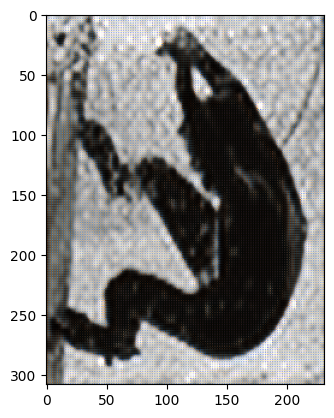

In [29]:
import matplotlib.pyplot as plt
plt.imshow(best_result['A man riding a wave on top of a surfboard.']['output'][0].transpose(2,1,0))

In [29]:
save_imgs(best_result, f'resultsX{down_scale}x2withDetection_1e-6')

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'resultsX8x2withDetection\\Three stuffed animals are sitting on a bed. \\three stuffed animals'

In [23]:
os.mkdir('./resultsX8x2withDetection\\Three stuffed animals are sitting on a bed.\\three stuffed animals')

'three stuffed animals'

In [31]:
down_scale

8

In [30]:
with open(file=f'resultsX{down_scale}x2withDetection_1e-6.pkl', mode='rb') as f:
    dicdic=pickle.load(f)

In [ ]:
dicdic

In [ ]:
best_result['Three stuffed animals are sitting on a bed. ']["phrases"][0][0]

In [ ]:
best_result['']

In [23]:
import pickle

with open(f'resultsX{down_scale}real_last.pkl','wb') as fw:
    pickle.dump(best_result, fw)

In [16]:
path = './result_model/X8_real_inverse_+_L1_&_L2_not_softmax.pt'
torch.save(best_model, path)

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

print("PSNR :", peak_signal_noise_ratio(Test_result_img['output'][0], Test_result_img['big_image'][0]))
print("SSIM :", structural_similarity((Test_result_img['output'][0]*255).astype(np.uint8), (Test_result_img['big_image'][0]*255).astype(np.uint8), channel_axis=2,multichannel=True))

In [15]:
nn.Parameter(torch.randn((64))).shape

torch.Size([64])

In [16]:
nn.Parameter(torch.ones((64))).shape

torch.Size([64])

In [59]:
import torch.nn as nn
import torch
sf = nn.Softmax()

a = nn.Parameter(torch.randn((1,1,64,64)))
b = nn.Parameter(torch.randn(1,128,64,64))
print(sf(b).max(dim=1)[0].shape)
print((a.flatten()@b.mean(dim=1).flatten()).shape)


torch.Size([1, 64, 64])
torch.Size([])


C:\Users\juniy\AppData\Local\Temp\ipykernel_14140\2370105043.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(sf(b).max(dim=1)[0].shape)


In [37]:
b.mean(dim=1).shape

torch.Size([1, 64, 64])

In [53]:
torch.dot(a.view(-1,64), b.mean(dim=1).view(-1,64))

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [70]:
sf = nn.Softmax(dim=-1)
sf(a@b.mean(dim=1).transpose(-2,-1)).shape

torch.Size([1, 1, 64, 64])